In [1]:
# Necessary imports

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:

# Load the dataset
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data", header=None)

data.head()


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [3]:
# Separating features and target
X = data.iloc[:, 2:].values
y = data.iloc[:, 1].values

# Encoding target variable: Malignant (M) as 1, Benign (B) as 0
y = np.where(y == "M", 1, 0)

# Split the dataset to keep aside 100 samples from each class for testing
class_0_indices = np.where(y == 0)[0]
class_1_indices = np.where(y == 1)[0]

X_class_0 = X[class_0_indices]
X_class_1 = X[class_1_indices]
y_class_0 = y[class_0_indices]
y_class_1 = y[class_1_indices]

# Separate 100 samples from each class for the test set
X_test_class_0, X_train_class_0 = X_class_0[:100], X_class_0[100:]
X_test_class_1, X_train_class_1 = X_class_1[:100], X_class_1[100:]
y_test_class_0, y_train_class_0 = y_class_0[:100], y_class_0[100:]
y_test_class_1, y_train_class_1 = y_class_1[:100], y_class_1[100:]

# Combine the class-separated training and test sets
X_train = np.concatenate((X_train_class_0, X_train_class_1))
y_train = np.concatenate((y_train_class_0, y_train_class_1))
X_test_small = np.concatenate((X_test_class_0, X_test_class_1))
y_test_small = np.concatenate((y_test_class_0, y_test_class_1))



In [4]:

np.random.seed(42)

# Determine the number of samples in the minority class
minority_class_size = min(len(X_train_class_0), len(X_train_class_1))

# Calculate the number of samples to duplicate from the majority class
majority_class_size = 3 * minority_class_size - len(X_train_class_1)

# Randomly select samples to duplicate from the majority class
indices_to_duplicate = np.random.choice(len(X_train_class_1), majority_class_size, replace=True)

# Extract the samples to be duplicated
X_to_duplicate = X_train_class_1[indices_to_duplicate]
y_to_duplicate = y_train_class_1[indices_to_duplicate]

# Add noise to the duplicated samples
noise_factor = 0.01
noise = noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_to_duplicate.shape)
X_to_duplicate_noisy = X_to_duplicate + noise

# Combine the original training data with the noisy duplicates
X_train_imbalanced = np.vstack((X_train, X_to_duplicate_noisy))
y_train_imbalanced = np.hstack((y_train, y_to_duplicate))


In [5]:
# Calculate the number of labels to flip for each class
num_to_flip_class_0 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 0]))
num_to_flip_class_1 = int(0.05 * len(y_train_imbalanced[y_train_imbalanced == 1]))

# Randomly choose the indices of labels to flip
indices_to_flip_class_0 = np.random.choice(np.where(y_train_imbalanced == 0)[0], num_to_flip_class_0, replace=False)
indices_to_flip_class_1 = np.random.choice(np.where(y_train_imbalanced == 1)[0], num_to_flip_class_1, replace=False)

# Flip the labels
y_train_imbalanced[indices_to_flip_class_0] = 1
y_train_imbalanced[indices_to_flip_class_1] = 0



In [6]:

# Determine the number of input features (number of columns in X_train_imbalanced)
input_dim = X_train_imbalanced.shape[1]
print(input_dim)

# Create the neural network model with one hidden layer of size twice the number of input features
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Compile the model with binary crossentropy loss and the ADAM optimizer
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


30


7/7 [==============================] - 0s 471us/step


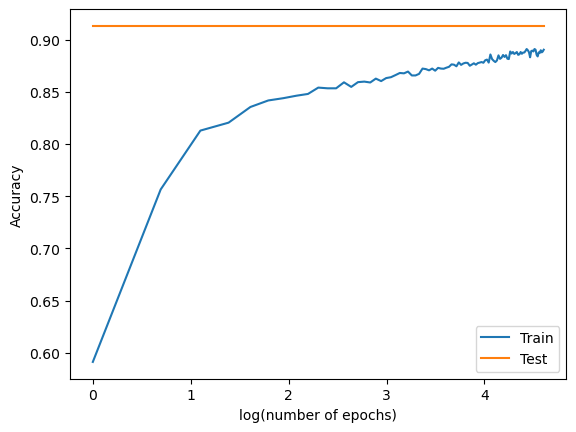

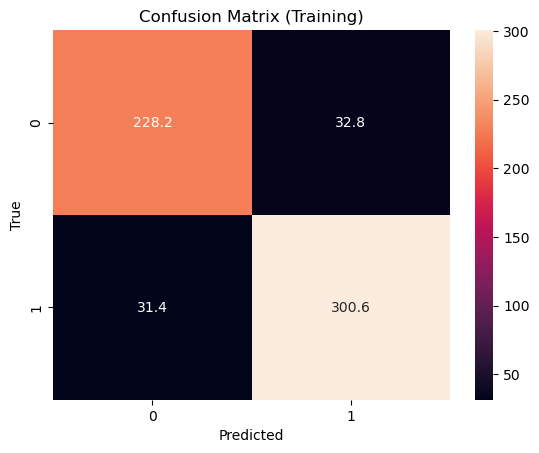

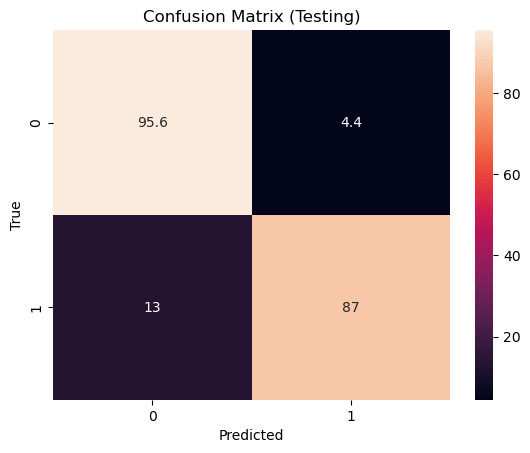

In [7]:


results_train = []
results_test = []
conf_mat_train = []
conf_mat_test = []
weights_list = []

for i in range(10): 
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Train the model
    history = model.fit(X_train_imbalanced, y_train_imbalanced, epochs=100, verbose=0)

    # Save the weights
    weights = model.get_weights()
    weights_list.append(weights)

    # Evaluate the model
    train_acc = history.history['accuracy']
    test_acc = model.evaluate(X_test_small, y_test_small, verbose=0)[1]

    # Save the results
    results_train.append(train_acc)
    results_test.append(test_acc)

    # Confusion matrices
    y_pred_train = (model.predict(X_train_imbalanced) > 0.5).astype(int)
    y_pred_test = (model.predict(X_test_small) > 0.5).astype(int)

    conf_mat_train.append(confusion_matrix(y_train_imbalanced, y_pred_train))
    conf_mat_test.append(confusion_matrix(y_test_small, y_pred_test))

# Calculate the mean results
mean_results_train = np.mean(results_train, axis=0)
mean_results_test = np.mean(results_test)

# Plot the results
plt.plot(np.log(range(1, 101)), mean_results_train, label="Train")
plt.plot(np.log(range(1, 101)), [mean_results_test] * 100, label="Test")
plt.xlabel("log(number of epochs)")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Confusion matrices
mean_conf_mat_train = np.mean(conf_mat_train, axis=0)
mean_conf_mat_test = np.mean(conf_mat_test, axis=0)

# Plotting confusion matrices
plt.figure()
sns.heatmap(mean_conf_mat_train, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Training)")
plt.show()

plt.figure()
sns.heatmap(mean_conf_mat_test, annot=True, fmt="g")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Testing)")
plt.show()

# Saving weights
file = open('weights.txt', 'w')
file.write(str(weights_list))
file.close()


In [8]:
def initialize_population(input_dim, population_size):
    """
    This function initializes a population of neural network weights.
    Each individual in the population is a list of weight matrices for each layer of the neural network.
    """
    population = []
    for _ in range(population_size):
        individual = [
            np.random.randn(input_dim, 2 * input_dim),  # Weights for the first layer (input to hidden)
            np.random.randn(2 * input_dim),             # Biases for the first layer
            np.random.randn(2 * input_dim, 1),          # Weights for the second layer (hidden to output)
            np.random.randn(1)                          # Bias for the second layer
        ]
        population.append(individual)
    return population

# Now we'll reinitialize the population with the corrected weight shapes.
population_size = 4 + input_dim**2  # Population size for (4+d^2) ES
population = initialize_population(input_dim, population_size)


In [9]:
def recombine(parent1, parent2):
    """
    Perform arithmetic recombination (simple averaging) between two parents to create an offspring.
    """
    offspring = [(p1 + p2) / 2 for p1, p2 in zip(parent1, parent2)]
    return offspring

def mutate(individual, mutation_rate):
    """
    Apply Gaussian mutation to an individual. Each weight is perturbed by a value drawn from
    a Gaussian distribution with mean 0 and standard deviation equal to mutation_rate.
    """
    mutated_individual = [weights + np.random.normal(0, mutation_rate, size=weights.shape) 
                          for weights in individual]
    return mutated_individual

def fitness_function(model, weights, X, y):
    """
    Evaluate the fitness of an individual. The fitness is the negative of the loss on the training data,
    since we want to minimize the loss, or maximize the negative loss.
    """
    model.set_weights(weights)
    loss, accuracy = model.evaluate(X, y, verbose=0)
    return -loss  # Return negative loss as the fitness

# Set the initial mutation rate
initial_mutation_rate = 0.1  # This can be tuned

# Create the neural network template to be used for fitness evaluation
model = tf.keras.Sequential([
    tf.keras.layers.Dense(2 * input_dim, input_dim=input_dim, activation='sigmoid'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


In [10]:
import copy
import time

# Set constants for the ES algorithm
num_generations = 16  # Total number of generations to run
num_trials = 10        # Number of trials to perform
recorded_generations = [1, 2, 4, 8, 16]  # Generations at which to record fitness

# Prepare to record the statistics
generation_fitness = {generation: [] for generation in recorded_generations}
trial_fitness = []

for trial in range(num_trials):
    print(f"Starting trial {trial+1}/{num_trials}")
    start_time = time.time()
    
    # Initialize the population for this trial
    population = initialize_population(input_dim, population_size)
    
    # Evaluate the initial population
    fitness_scores = [fitness_function(model, individual, X_train_imbalanced, y_train_imbalanced) 
                      for individual in population]
    
    # Record the highest initial fitness if generation 1 is in recorded generations
    if 1 in generation_fitness:
        trial_fitness.append(max(fitness_scores))
        print(f"Initial population evaluated. Highest fitness: {max(fitness_scores)}")
    
    # Adaptation: Initialize mutation rate
    mutation_rate = initial_mutation_rate
    gen = 1
#     while gen <= num_generations or check_convergence(population)
    for generation in range(1, num_generations + 1):
        # Create the next generation
        new_population = []
        while len(new_population) < population_size:
            # Select two parents randomly by index
            parent_indices = np.random.randint(len(population), size=2)
            parents = [population[parent_indices[0]], population[parent_indices[1]]]
            
            # Recombine parents
            offspring = recombine(parents[0], parents[1])
            
            # Mutate offspring
            offspring = mutate(offspring, mutation_rate)
            
            # Add to new population
            new_population.append(offspring)
        
        # Evaluate the new population
        new_fitness_scores = [fitness_function(model, individual, X_train_imbalanced, y_train_imbalanced) 
                              for individual in new_population]
        
        # Select the best individuals to form the new population
        best_indices = np.argsort(new_fitness_scores)[-population_size:]
        population = [new_population[i] for i in best_indices]
        fitness_scores = [new_fitness_scores[i] for i in best_indices]
        
        # Record the highest fitness of this generation if it's one of the recorded generations
        if generation in generation_fitness:
            generation_fitness[generation].append(max(fitness_scores))
            print(f"Generation {generation}: Highest fitness = {max(fitness_scores)}")

        # Adaptation: Adjust mutation rate using the 1/5 rule
        successful_mutations = sum(f > f_old for f, f_old in zip(new_fitness_scores, fitness_scores))
        success_ratio = successful_mutations / population_size
        if success_ratio > 0.2:
            mutation_rate *= 1.2
        elif success_ratio < 0.2:
            mutation_rate /= 1.2

        # Progress output
        print(f"Trial {trial+1}, Generation {generation} complete.", end="\r")

    end_time = time.time()
    print(f"Trial {trial+1} completed in {end_time - start_time:.2f} seconds.")

# Calculate the average and standard deviation of the highest fitness at each recorded generation
for generation in generation_fitness:
    avg_fitness = np.mean(generation_fitness[generation])
    std_fitness = np.std(generation_fitness[generation])
    print(f"Generation {generation}: Avg fitness = {avg_fitness}, Std fitness = {std_fitness}")

# If generation 1 was not in recorded generations, calculate initial fitness statistics here
if 1 not in generation_fitness:
    avg_initial_fitness = np.mean(trial_fitness)
    std_initial_fitness = np.std(trial_fitness)
    print(f"Initial: Avg fitness = {avg_initial_fitness}, Std fitness = {std_initial_fitness}")


Starting trial 1/10
Initial population evaluated. Highest fitness: -0.45476219058036804
Generation 1: Highest fitness = -0.4421425759792328
Generation 2: Highest fitness = -0.46312281489372253
Generation 4: Highest fitness = -0.554352343082428
Generation 8: Highest fitness = -0.5509597063064575
Generation 16: Highest fitness = -0.49881237745285034
Trial 1 completed in 440.62 seconds.
Starting trial 2/10
Initial population evaluated. Highest fitness: -0.42020195722579956
Generation 1: Highest fitness = -0.4616437256336212
Generation 2: Highest fitness = -0.4284210205078125
Generation 4: Highest fitness = -0.5640901327133179
Generation 8: Highest fitness = -0.5486599802970886
Generation 16: Highest fitness = -0.4685359001159668
Trial 2 completed in 436.28 seconds.
Starting trial 3/10
Initial population evaluated. Highest fitness: -0.44198042154312134
Generation 1: Highest fitness = -0.45828777551651
Generation 2: Highest fitness = -0.5019837617874146
Generation 4: Highest fitness = -0.52

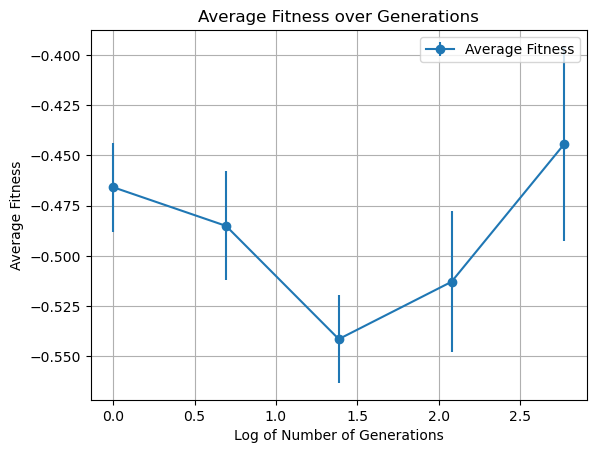

In [11]:
import matplotlib.pyplot as plt

# Prepare the data for plotting
generations = np.array(recorded_generations)
avg_fitness = np.array([np.mean(generation_fitness[gen]) for gen in generations])
std_fitness = np.array([np.std(generation_fitness[gen]) for gen in generations])

# Plot the average fitness against log of the number of generations
plt.errorbar(np.log(generations), avg_fitness, yerr=std_fitness, label='Average Fitness', fmt='-o')

plt.xlabel('Log of Number of Generations')
plt.ylabel('Average Fitness')
plt.title('Average Fitness over Generations')
plt.legend()
plt.grid(True)
plt.show()


7/7 [==============================] - 0s 468us/step


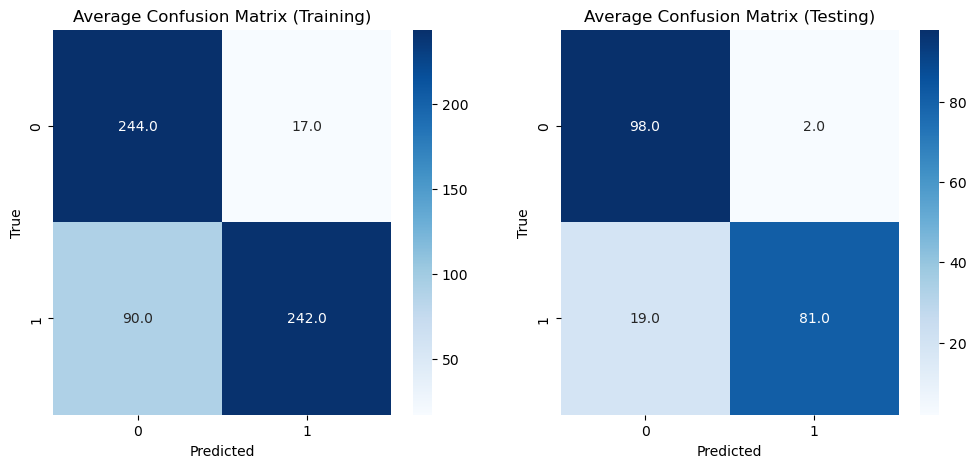

In [12]:
from sklearn.metrics import confusion_matrix

# Function to compute confusion matrix for a given set of weights
def compute_confusion_matrix(model, weights, X, y_true):
    model.set_weights(weights)
    y_pred = (model.predict(X) > 0.5).astype(int)
    return confusion_matrix(y_true, y_pred)

# Initialize sums of confusion matrices
conf_matrix_sum_train = np.zeros((2, 2), dtype=int)
conf_matrix_sum_test = np.zeros((2, 2), dtype=int)

for trial in range(num_trials):
    # Retrieve the best individual from the last generation of this trial
    best_weights = population[np.argmax(fitness_scores)]

    # Compute and add the confusion matrix for the training data
    conf_matrix_train = compute_confusion_matrix(model, best_weights, X_train_imbalanced, y_train_imbalanced)
    conf_matrix_sum_train += conf_matrix_train

    # Compute and add the confusion matrix for the test data
    conf_matrix_test = compute_confusion_matrix(model, best_weights, X_test_small, y_test_small)
    conf_matrix_sum_test += conf_matrix_test

# Compute the average confusion matrices
avg_conf_matrix_train = conf_matrix_sum_train / num_trials
avg_conf_matrix_test = conf_matrix_sum_test / num_trials

# Plotting the average confusion matrices
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(avg_conf_matrix_train, annot=True, fmt=".1f", ax=ax[0], cmap="Blues")
ax[0].set_title('Average Confusion Matrix (Training)')
ax[0].set_xlabel('Predicted')
ax[0].set_ylabel('True')

sns.heatmap(avg_conf_matrix_test, annot=True, fmt=".1f", ax=ax[1], cmap="Blues")
ax[1].set_title('Average Confusion Matrix (Testing)')
ax[1].set_xlabel('Predicted')
ax[1].set_ylabel('True')

plt.show()
